<h1>Pizza Preference KNN</h1>
<p>Nicolás Penagos</p>
<p>Andrea Torrente</p>

<h3>0. Project setup</h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb
import random

"""
1. Load data
"""
df = pd.read_csv('./data/pizza_preference_dataset.csv')

"""
2. Setup widgets
"""
import ipywidgets as widgets

# selected_student (dropdown)
selected_student = df.values[0][0]

dropdown = widgets.Dropdown(options=df['Nombre'].values, description='Select a student:')

def handle_dropdown_change(change):
    global selected_student
    selected_student = change.new

dropdown.observe(handle_dropdown_change, names='value')

# k_neighbors (input)

k_neighbors = 1

numeric_input = widgets.BoundedIntText(
    value=k_neighbors,
    min=1,
    max=df.shape[0]-1,
    step=1,
    description='k_neighbors:'
)

def on_numeric_input_change(change):
    global k_neighbors
    k_neighbors = change.new
    
numeric_input.observe(on_numeric_input_change, names='value')


"""
2. Utils functions
"""
def get_index_by_name(name):
    return df[df['Nombre']== name].index.values[0]

def get_name_by_index(index): 
    return df.loc[index, 'Nombre']

def format_names_array(names_list):
    msg = ''
    for i in range(len(names_list)):
        msg +=str(i+1)+'. '+names_list[i] +'\n'
    return msg
            
def shuffle_lists(list1, list2):
 
    combined = list(zip(list1, list2))
    random.shuffle(combined)
    shuffled_list1, shuffled_list2 = zip(*combined)
    
    return list(shuffled_list1), list(shuffled_list2)

def plot_polar_distances(x,y,labels,x_dist,y_dist,labels_dist):


    fig, ax = plt.subplots(figsize=(9, 9))

    ax.grid(False)
    ax.axis('off')
    
    for i, label in enumerate(labels_dist):
        ax.annotate(label, (x_dist[i], y_dist[i]), textcoords="offset points", xytext=(0, 0), ha='center', color='#0472A2', fontsize=12)
    
    for i, label in enumerate(labels):
        ax.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0, 10), ha='center', color=('black', '#4B4B4B')[i>0], weight=('bold', 'regular')[i>0])

    for i in range(len(x)):
        ax.plot([0, x[i]], [0, y[i]], 'gray')
        
    ax.scatter(x, y)

    ax.set_title('Knn weighted graph respect to: '+labels[0], color='black', weight='bold')

    plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)

    plt.show()

<h3>1. Start here</h3>

In [2]:
df

,Nombre,Carne Molida,Chorizo,Jamón,Pepperoni,Pollo,Salami,Tocineta,Aceituna,Cebolla,Champiñón,Ciruela,Jalapeño,Maíz Tierno,Orégano,Pimentón,Piña,Tomate
0,Tatiana Campos,8,3,3,7,10,5,1,1,1,7,9,1,1,10,9,10,10
1,juan agredo,3,7,9,10,8,9,10,1,7,9,1,8,10,8,8,9,9
2,Andrea Torrente,10,8,10,10,8,10,7,1,5,5,2,1,8,4,1,10,8
3,Yajhaira Naranjo,9,9,8,9,6,5,10,10,5,4,8,6,10,6,6,8,10
4,Juan Munera,10,10,10,10,10,10,10,3,8,7,1,1,8,10,5,10,5
5,Valeria Jiménez,4,1,7,9,10,6,3,5,8,10,5,5,1,10,10,1,10
6,Juan Andrés López,7,10,6,10,10,10,9,9,10,10,4,8,4,10,3,10,7
7,Andres Felipe Narvaez Estrella,3,7,10,10,8,10,9,6,8,8,5,3,10,8,6,10,10
8,Luisa Tapiero,7,9,9,10,10,10,10,3,2,10,1,6,7,10,1,5,10
9,Alejandro Medina,7,7,9,6,10,9,10,2,3,7,1,1,6,8,1,2,10


In [3]:
display(dropdown)
display(numeric_input)

Dropdown(description='Select a student:', options=('Tatiana Campos', 'juan agredo', 'Andrea Torrente', 'Yajhai…

BoundedIntText(value=1, description='k_neighbors:', max=19, min=1)

<h3>2. Nearest Neighbors List </h3>

In [6]:
from sklearn.neighbors import NearestNeighbors

# Transform numeric data to an array
X = df[df.columns[1:]].to_numpy()

# Setup the model
nbrs = NearestNeighbors(n_neighbors=k_neighbors+1, algorithm='ball_tree').fit(X)

# distances = an array of distances between the k-nearest neighbors 
# indices = indices of the k-nearest neighbors
#
# (the nearest neighbor of each point is the point itself for both cases)

distances, indices = nbrs.kneighbors(X)


# Get index by name
index = get_index_by_name(selected_student)

k_nearest_to_index = indices[index][1:]

k_nearets_names = list(map(get_name_by_index, k_nearest_to_index))

print('\033[40m\033[90m---------------------------- OUTPUT -------------------------------\033[00m\n\nThe \033[91m{}-nearest\033[00m neighbor(s) of \033[91m{}\033[00m is/are:\n\n{}'.format(k_neighbors,get_name_by_index(index),format_names_array(k_nearets_names)), '\n\n\033[40m-------------------------------------------------------------------')

---------------------------- OUTPUT -------------------------------

The 19-nearest neighbor(s) of Sebastian Mosquera is/are:

1. Andrés Camilo Gómez Amaya
2. Juan Rodriguez
3. Nicolas Orozco
4. Christian Aparicio
5. Yajhaira Naranjo
6. Juan Andrés López 
7. Andres Felipe Narvaez Estrella
8. Isabella Pinzon 
9. Christian Castro
10. juan agredo
11. Juan Munera
12. Cristian guevara
13. Valeria Jiménez 
14. Luisa Tapiero
15. Andrea Torrente
16. Tatiana Campos
17. Nicolas Penagos
18. Alejandro Medina
19. Juan Bueno
 

-------------------------------------------------------------------


<h3>3. KNN Weighted graph</h3>

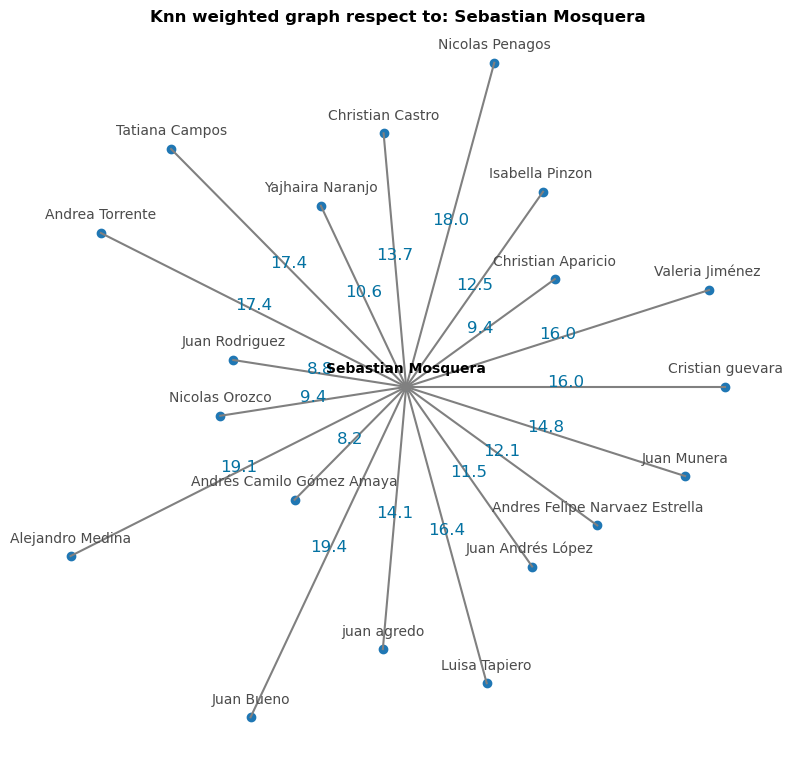

In [7]:
import matplotlib.pyplot as plt
import math

distances_to_plot, indices_to_plot = shuffle_lists(distances[index][1:], indices[index][1:]) 

# Compute polar distances
spread_angle = 360 / len(distances_to_plot)
x = [0]
y = [0]
x_dist = []
y_dist = []
labels = [get_name_by_index(index)]
labels_dist = []


for i in range(len(distances_to_plot)):
    theta = spread_angle * i
    x.append(distances_to_plot[i] * math.cos(math.radians(theta)))
    y.append(distances_to_plot[i] * math.sin(math.radians(theta)))
    x_dist.append(distances_to_plot[i]/2 * math.cos(math.radians(theta)))
    y_dist.append(distances_to_plot[i]/2 * math.sin(math.radians(theta)))
    labels_dist.append(round(distances_to_plot[i], 1))
    labels.append(get_name_by_index(indices_to_plot[i]))

plot_polar_distances(x,y,labels,x_dist,y_dist,labels_dist)